## 🧠 Projet : Détection des clignements d’yeux avec un CNN pour décoder du Morse

Ce projet implémente un **réseau de neurones convolutif (CNN)** pour détecter automatiquement si les **yeux sont ouverts ou fermés** à partir d'images, dans le but d’être utilisé comme **composant de base** dans un projet plus large : **le décodage du code Morse à partir des clignements d’yeux**.

L’idée est d’utiliser ce modèle pour reconnaître en temps réel les **états de l’œil (ouvert ou fermé)**, puis de **traduire les clignements (courts et longs)** en symboles Morse (`.` et `-`). Ce système peut être appliqué dans des contextes d’accessibilité, de communication assistée ou d’interfaces homme-machine.

---

## 📦 Pipeline du projet

Ce code réalise les étapes suivantes :

- 🔄 **Prétraitement des données** : les images sont redimensionnées et normalisées à l’aide de `ImageDataGenerator`.
- 👁️ **Affichage d’un échantillon** : pour vérifier que les images sont bien classées (œil ouvert ou fermé).
- 🧱 **Construction du modèle CNN** : avec plusieurs couches de convolution, de pooling et de dropout pour éviter l’overfitting.
- ⚙️ **Compilation, entraînement et évaluation** : le modèle est compilé avec l’optimiseur Adam et évalué sur un jeu de test.
- 💾 **Sauvegarde et visualisation du modèle** : le modèle entraîné est sauvegardé et sa structure est exportée sous forme d’image pour documentation et intégration.

---

## 🎯 Objectif

Le modèle entraîné sera intégré dans un système temps réel de **décodage du code Morse basé sur les clignements d’yeux**, où la séquence de clignements (courts et longs) détectée sera traduite automatiquement en texte lisible.


In [ ]:
# Importation des bibliothèques nécessaires
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle
import shutil
import random
import pathlib
import tensorflow as tf
import keras
import sklearn

In [8]:
# Prétraitement des données : normalisation des pixels
train_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)
# Chargement des images depuis les dossiers avec data augmentation 
train_gen = train_data.flow_from_directory(
    'eye_data/train/',
    target_size=(64, 64),
   
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

test_gen = test_data.flow_from_directory(
    'eye_data/test/',
    target_size=(64, 64),
    
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 139804 images belonging to 2 classes.
Found 6991 images belonging to 2 classes.


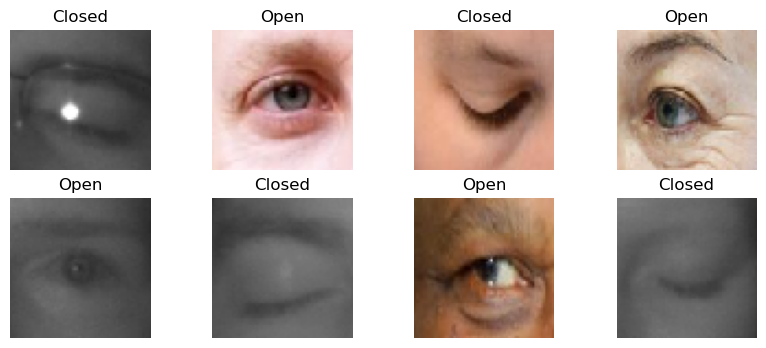

In [9]:
# Fonction utilitaire pour afficher un échantillon d’images du générateur
def show_sample(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 4))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Open" if labels[i]==1 else "Closed")
        plt.axis('off')
    plt.show()

show_sample(train_gen)


In [14]:
# Construction du modèle CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [15]:
# Compilation et entraînement du modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, epochs=10, validation_data=test_gen)


Epoch 1/10


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4369/4369 ━━━━━━━━━━━━━━━━━━━━ 2447s 558ms/step - accuracy: 0.9074 - loss: 0.2237 - val_accuracy: 0.9654 - val_loss: 0.1041
Epoch 2/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 1052s 241ms/step - accuracy: 0.9639 - loss: 0.1001 - val_accuracy: 0.9748 - val_loss: 0.0695
Epoch 3/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 787s 180ms/step - accuracy: 0.9744 - loss: 0.0698 - val_accuracy: 0.9787 - val_loss: 0.0559
Epoch 4/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 530s 121ms/step - accuracy: 0.9797 - loss: 0.0559 - val_accuracy: 0.9830 - val_loss: 0.0471
Epoch 5/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 505s 115ms/step - accuracy: 0.9831 - loss: 0.0461 - val_accuracy: 0.9837 - val_loss: 0.0456
Epoch 6/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 482s 110ms/step - accuracy: 0.9849 - loss: 0.0411 - val_accuracy: 0.9854 - val_loss: 0.0396
Epoch 7/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 494s 113ms/step - accuracy: 0.9869 - loss: 0.0365 - val_accuracy: 0.9864 - val_loss: 0.0376
Epoch 8/10
4369/4369 ━━━━━━━━━━━━━━━━━━━━ 530s 121ms/step - accuracy: 0

In [16]:
# Sauvegarde du modèle entraîné
model.save("eye_blink_cnn_model.h5")

In [17]:
# Évaluation du modèle sur le jeu de test
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")


219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9805 - loss: 0.0498
Test Accuracy: 98.93%


In [9]:
!pip install pydot
!pip install graphviz



=== Model Summary ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,331 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

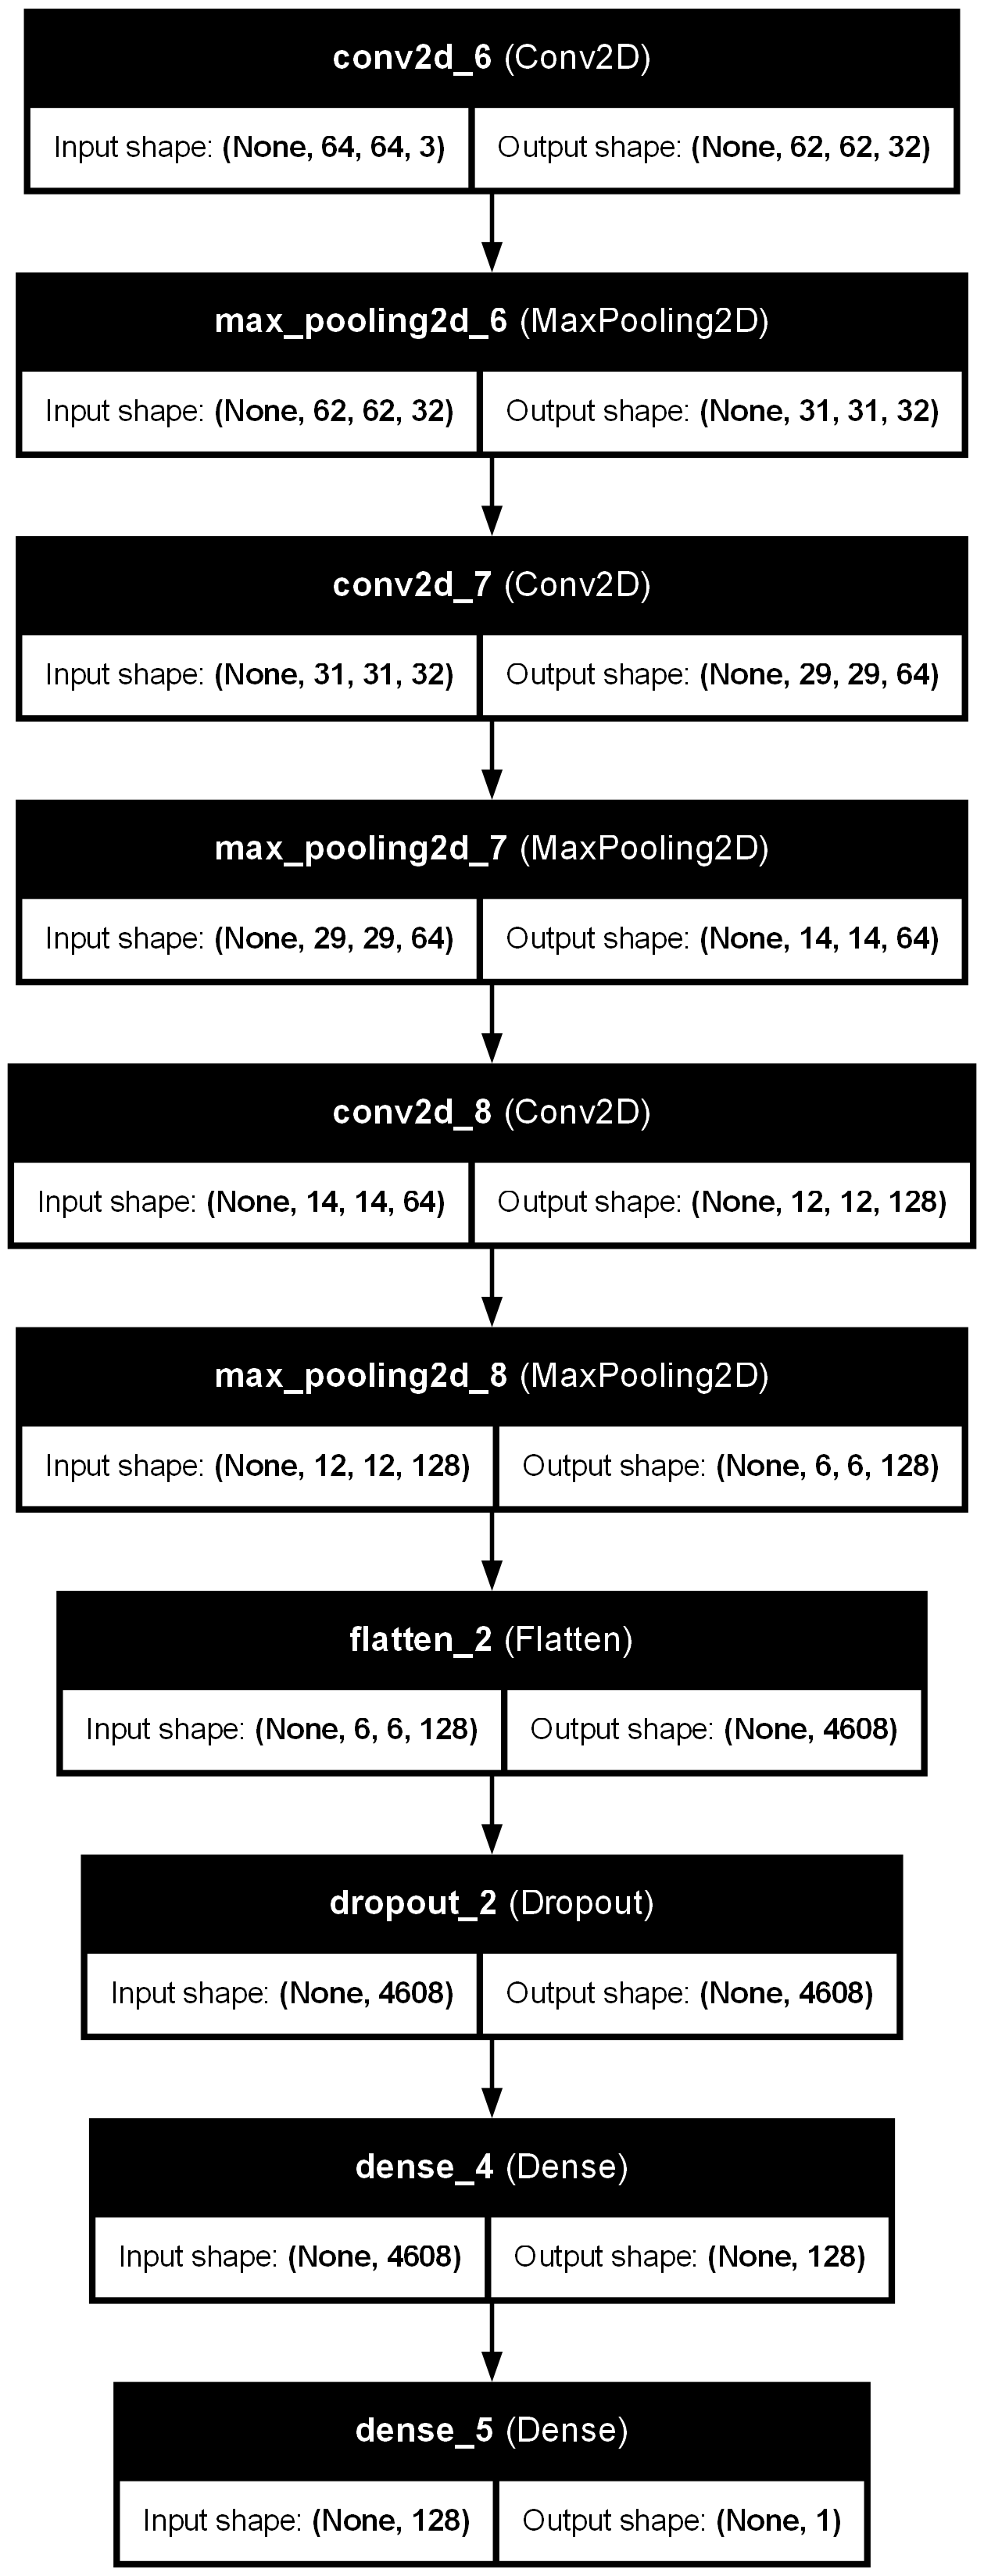

In [3]:
# Importation des outils pour afficher la structure du modèle
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import IPython.display as display
from PIL import Image

# Charger le modèle sauvegardé
model = load_model("eye_blink_cnn_model.h5")

# Afficher un résumé textuel du modèle
print("=== Model Summary ===")
model.summary()

# Sauvegarder la structure du modèle sous forme d'image
plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,         # Affiche les dimensions d'entrée/sortie
    show_layer_names=True     # Affiche les noms des couches
)

# Afficher l'image générée dans un Jupyter Notebook
img = Image.open("model_architecture.png")
display.display(img)
